In [1]:
import warnings # Will be used to ignore the unnecessary warning so that the code look good esthetically
warnings.filterwarnings('ignore')

In [2]:
# import required libraries
%matplotlib inline
from scipy.interpolate import CubicSpline  # For  interpolation functions
import matplotlib.pyplot as plt
import seismic.additional_functions as seis # library created for the purpose of this lecture series, explore further if interested!
import numpy as np
import segyio
import os

## Practical 2: Conducting NMO corrections with a real CMP gather

In this section you will load a segy file of a real CMP gather and conduct your own NMO correction, courtesy of Rob allen from the VoilA project. You will quickly see that the reality of the situation is more complex then our examples above and there is a need to develop better methods to cope with real seismic data. 

this first section will walk you through how to read in the data, an understanding of how the segyio package works will be developed on Thursday. Once the data is read in, use your prior written functions or the prewritten functions to try and obtain an NMO correction section.

In [3]:
# pointer to data
file = 'data/VoiLALine1_CDP4000_RA.segy'
assert os.path.exists(file), 'file cannot be found on given path' 
# load data
f = segyio.open(file, ignore_geometry= False) #opens files like python default open call
# extract data from file
data = f.trace.raw[:].T
# get key parameters from dataset
dt = (f.samples[1] - f.samples[0]) / 1000 # timestep in s
offsets = abs(f.offsets) #number of receivers / traces
cmp = data # data for each trace
nsamples = cmp.shape[0]
noffsets = cmp.shape[1]
times = np.arange(nsamples)*dt # times

Text(0, 0.5, 'Time (s)')

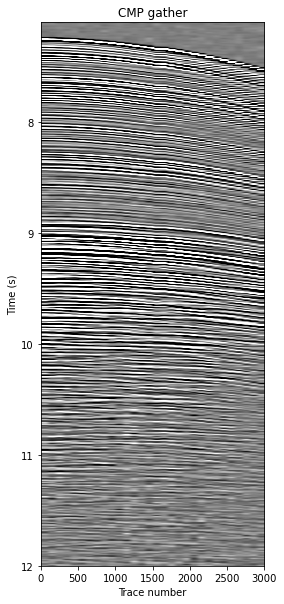

In [4]:
#set cut-off for better visualisation
vm = np.percentile(data, 95)
vmin, vmax = -vm, vm

# set correct axis ranges
extent = [0, data.shape[0], np.max(times), 7.1]
cut = 7100 #starting point in y-axis, no data above this time due to shot/receiver gap
start = int((cut/np.max(f.samples)) * np.shape(data)[0]) #index value for cut

plt.figure(figsize = (4,10))
plt.imshow(data[start:,:], extent= extent, aspect = 'auto', cmap='gray', vmin=vmin, vmax=vmax)
plt.title('CMP gather')
plt.xlabel('Trace number')
plt.ylabel('Time (s)')


**Excersice: try around some velocities that are too low and too high to see the impact, can you explain what happens at these ranges?**  vary values (as a minimum try 1000, 1500, 3000)

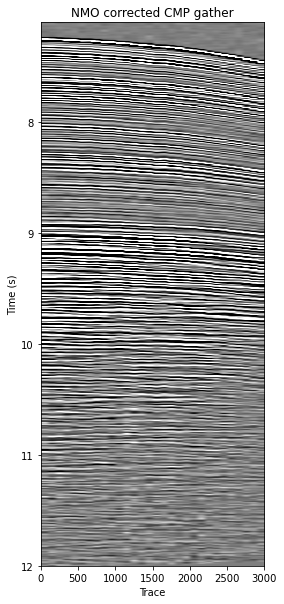

In [5]:
vel = 3000 # vary values (as a minimum try 1000, 1500, 3000)

v_nmo = np.ones(len(times))*vel # constant velocity array for NMO correction
nmo = seis.nmo_correction(cmp, dt, offsets, v_nmo) # NMO correction
    
plt.figure(figsize = (4,10))
plt.imshow(nmo[start:,:], extent= extent, aspect = 'auto', cmap='gray', vmin=vmin, vmax=vmax)
plt.title('NMO corrected CMP gather')
plt.xlabel('Trace')
plt.ylabel('Time (s)')
plt.show()

In [6]:
num = 10 # number of velocities to be test (semblance plot resolution)
v_test = np.linspace(1000, 4000, num) # V testing range: [minimum velocity, maximum velocity, number of intervals in between]
amp_store = seis.semblance(v_test, cmp, dt, offsets, times, verbose = True)
amp_store = np.array(amp_store)

progress =  10.0 %
progress =  20.0 %
progress =  30.0 %
progress =  40.0 %
progress =  50.0 %
progress =  60.0 %
progress =  70.0 %
progress =  80.0 %
progress =  90.0 %
progress =  100.0 %


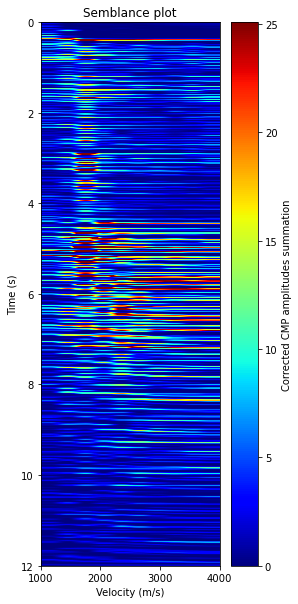

In [7]:
# visualise semblance plot

# clip outlier values for improved visualisation
vm = np.percentile(amp_store.clip(0, np.max(amp_store)), 99) 
vmin, vmax = 0, vm

plt.figure(figsize = (4,10))
plt.imshow(np.swapaxes(amp_store,0,1 )[start:,:].clip(0, np.max(amp_store)),extent=[np.min(v_test), np.max(v_test),
                                            dt*nsamples, 0], aspect="auto",cmap='jet', vmin=vmin, vmax=vmax)

plt.title ('Semblance plot')
plt.colorbar(label = 'Corrected CMP amplitudes summation')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Time (s)')
plt.show()

[[122, 579]]
[[122, 579], [138, 677]]
[[122, 579], [138, 677], [144, 730]]
[[122, 579], [138, 677], [144, 730], [183, 752]]
[[122, 579], [138, 677], [144, 730], [183, 752], [324, 755]]
[[122, 579], [138, 677], [144, 730], [183, 752], [324, 755], [324, 806]]
NMO_vel=  1666 | time =  7.236
NMO_vel=  1666 | time =  8.464
NMO_vel=  1666 | time =  9.128
NMO_vel=  2000 | time =  9.4
NMO_vel=  3000 | time =  9.44
NMO_vel=  3000 | time =  10.076


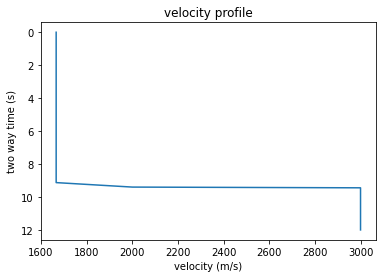

In [8]:
NMO_val = seis.click(amp_store, v_test, times) # right click to obtain data, escape to close window
v_nmo = seis.vel_curve (amp_store, NMO_val, times) # create array containing velocity profile
nmo = seis.nmo_correction(cmp, dt, offsets, v_nmo) # carry out correction, you can use your own NMO function

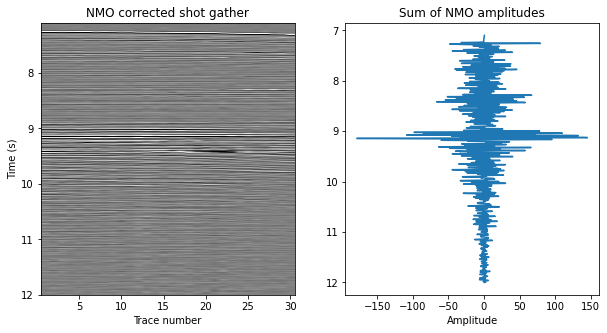

In [9]:
vm = np.percentile(nmo.clip(0, np.max(amp_store)), 99)
vmin, vmax = -vm, vm

fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].imshow(nmo[start:,:], extent=[0.5, noffsets + 0.5, np.max(times), cut/1000], 
          aspect="auto", cmap='gray', vmin=vmin, vmax=vmax)
ax[0].set_title('NMO corrected shot gather')
ax[0].set_xlabel('Trace number')
ax[0].set_ylabel('Time (s)')

ax[1].plot(np.sum(nmo, axis = 1)[start:], times[start:])
ax[1].set_title('Sum of NMO amplitudes')
ax[1].set_xlabel('Amplitude')
ax[1].invert_yaxis()

plt.show()